<a href="https://colab.research.google.com/github/amzad-786githumb/AI_and_ML_by-Microsoft/blob/main/22_Comparing_and_reinforcing_learning_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this assignment, you will use a simple grid environment (5 × 5) in which the agent starts at a random position and must navigate to a goal state while avoiding pitfalls. The environment includes:

**States:** each cell on the grid is a unique state.

**Actions:** the agent can move up, down, left, or right.

**Rewards:**

*  +10 for reaching the goal state (position 24).

*  –10 for falling into a pit (position 12).

*  –1 for all other movements (to encourage faster goal-reaching).

The objective is to compare how each algorithm—Q-learning and policy gradients—handles this environment and analyze their behavior.

<h3>Set up your environment</h3>

In [ ]:
pip install numpy tensorflow matplotlib

<h2><b>Implement Q-learning</b></h2>

<h3>Step 1: Initialize the Q-table</h3>

In [ ]:
import numpy as np

#Define the grid size and actions
grid_size = 5
n_actions = 4

#Initialize the Q table with zeros
Q_table = np.zeros((grid_size*grid_size, n_actions))

<h3>Step 2: Define the hyperparameters</h3>

In [ ]:
alpha = 0.1 #Learning rate
gamma = 0.9 #Discount factor for future rewards
epsilon = 0.1 #Exploration rate for epsilon-greedy policy

<h3>Step 3: Define the reward structure</h3>

In [ ]:
#reward matrix for grid environment
rewards = np.full((grid_size * grid_size, ), -1)
rewards[24] = 10 #goal state
rewards[12] =-10 #pitfall state

<h3>Step 4: Implement the epsilon-greedy action selection</h3>

In [ ]:
def epsilon_greedy_action(Q_table, state, epsilon):
  if np.random.uniform(0,1) < epsilon:
    return np.random.randint(0, n_actions)  #Explore random axtion
  else:
    return np.argmax(Q_table[state]) #Exploit: action with highest Q-value

<h3>Step 5: Update the Q-values</h3>

In [ ]:
# List to store cumulative rewards per episode for Q-learning
rewards_q_learning = []

for episode in range(1000):
    state = np.random.randint(0, grid_size * grid_size)  # Start in a random state
    done = False
    episode_cumulative_reward = 0  # Initialize cumulative reward for the episode
    while not done:
        action = epsilon_greedy_action(Q_table, state, epsilon)
        next_state = np.random.randint(0, grid_size * grid_size)  # Simulated next state
        reward = rewards[next_state]

        # Update Q-value using Bellman equation
        Q_table[state, action] = Q_table[state, action] + alpha * (reward + gamma * np.max(Q_table[next_state]) - Q_table[state, action])

        state = next_state
        episode_cumulative_reward += reward  # Add reward to episode cumulative reward
        if next_state == 24 or next_state == 12:
            done = True
    rewards_q_learning.append(episode_cumulative_reward)  # Store cumulative reward for the episode

<h2><b>Implement policy gradients</h2></b>

<h3>Step 1: Build the policy network</h3>

In [ ]:
import tensorflow as tf

# Define the policy network
n_states = grid_size * grid_size  # Number of states in the grid
n_actions = 4  # Up, down, left, right

model = tf.keras.Sequential([
    tf.keras.layers.Dense(24, activation='relu', input_shape=(n_states,)),
    tf.keras.layers.Dense(n_actions, activation='softmax')  # Output action probabilities
])

# Optimizer for policy network updates
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<h3>Step 2: Select an action</h3>

In [ ]:
def get_action(state):
    state_input = tf.one_hot(state, n_states)  # One-hot encoding for state
    action_probs = model(state_input[np.newaxis, :])
    return np.random.choice(n_actions, p=action_probs.numpy()[0])

<h3>Step 3: Simulate the environment</h3>

In [ ]:
# Simulation loop
states = []
actions = []
episode_rewards = []
rewards_policy_gradients = [] # List to store cumulative rewards per episode for Policy Gradients


for episode in range(1000):
    state = np.random.randint(0, n_states)  # Start in a random state
    done = False
    episode_cumulative_reward = 0 # Initialize cumulative reward for the episode
    while not done:
        action = get_action(state)  # Use the provided function
        next_state = np.random.randint(0, n_states)  # Simulated next state
        reward = rewards[next_state]

        # Store the state-action-reward trajectory
        states.append(state)
        actions.append(action)
        episode_rewards.append(reward)

        state = next_state
        episode_cumulative_reward += reward # Add reward to episode cumulative reward
        if next_state in {24, 12}:
            done = True
    rewards_policy_gradients.append(episode_cumulative_reward) # Store cumulative reward for the episode

<h3>Step 4: Compute cumulative rewards</h3>

In [ ]:
def compute_cumulative_rewards(rewards, gamma=0.99):
    cumulative_rewards = np.zeros_like(rewards)
    running_add = 0
    for t in reversed(range(len(rewards))):
        running_add = running_add * gamma + rewards[t]
        cumulative_rewards[t] = running_add
    return cumulative_rewards

<h3>Step 5: Update the policy</h3>

In [ ]:
def update_policy(states, actions, rewards):
    cumulative_rewards = compute_cumulative_rewards(rewards)

    with tf.GradientTape() as tape:
        state_inputs = tf.one_hot(states, n_states)  # Convert states to one-hot encoding
        action_probs = model(state_inputs)
        action_masks = tf.one_hot(actions, n_actions)  # Mask for selected actions
        log_probs = tf.reduce_sum(action_masks * tf.math.log(action_probs), axis=1)

        # Policy loss is the negative log-probability of the action times the cumulative reward
        loss = -tf.reduce_mean(log_probs * cumulative_rewards)

    # Apply gradients to update the policy network
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

<h2>Comparison and analysis</h2>

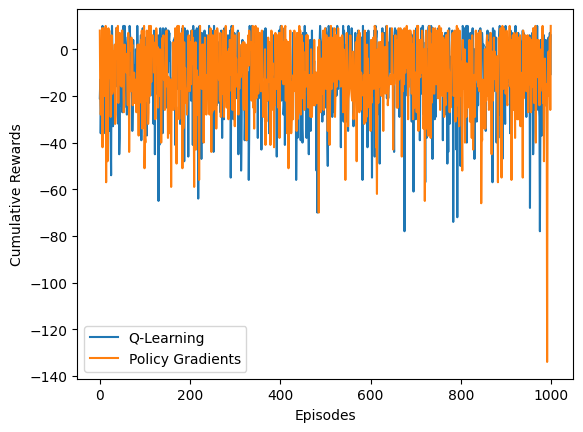

In [ ]:
import matplotlib.pyplot as plt

# Example code to visualize rewards over episodes
plt.plot(rewards_q_learning, label='Q-Learning')
plt.plot(rewards_policy_gradients, label='Policy Gradients')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Rewards')
plt.legend()
plt.show()

<h2>Comparing Q-learning and policy gradients</h2>

**Speed of convergence**

*  Q-learning tended to converge faster in this small grid environment. This is because Q-learning works well in environments with a discrete action space and fewer states, allowing the agent to build a reliable Q-table quickly.

*  Policy gradients required more episodes to stabilize because the agent learned the policy directly through gradient updates. However, policy gradients are more flexible in environments with continuous action spaces.

**Reward maximization**

*  Both algorithms eventually reached the goal consistently after enough episodes. However, Q-learning was more consistent in terms of reward maximization early on due to its more structured exploration.

*  Policy gradients started slowly but eventually caught up and produced comparable results.

**Exploration vs. exploitation**

*  Q-learning relies heavily on exploration through the epsilon-greedy policy. The agent systematically explored different paths, but it risked getting stuck in suboptimal actions when epsilon was too high.

*  Policy gradients did not explicitly balance exploration and exploitation; instead, they optimized the policy based on cumulative rewards, which naturally led to better action selection as the policy improved.

**Suitability for different problems**

*  Q-learning is more suited to environments with a small number of discrete actions and states, such as grid-based games or simple navigation tasks.

* Policy gradients are better suited for environments with a continuous action space or more complex scenarios where approximating a value function (such as Q-values) becomes difficult.